# Phishing Website Classification Analysis

This is a machine learning analysis of the 'Phishing Websites Data Set' hosted in the UCI Machine Learning Repository.

Feature descriptions for this data set are listed here: https://archive.ics.uci.edu/ml/machine-learning-databases/00327/Phishing%20Websites%20Features.docx

This analysis includes: 
- Data ingestion from the UCI repository 
- Data exploration and visualization 
- Data wrangling with Scikit-Learn transformers 
- A data loading and management strategy
- Fit and evaluatation of three estimators. 
- Use the best estimator to make predictions

# Import python packages required for analysis.

In [78]:
%matplotlib inline

import os
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.base import Bunch

import json
import time
import pickle
import csv

# Ingest dataset from the UCI repository. 

This section uses Requests to retreive the .arff dataset file from the UCI repo and writes the file to disk.

In [22]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00327/Training%20Dataset.arff"
    
def fetch_data(fname='Training_Dataset.arff'):
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    return outpath

# Fetch the data if required
data = fetch_data()
print (data)

SSLError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:645)

The .arff file needs to be converted to to a .csv file, so the data can be read-in to a pandas dataframe for initial analysis. I did this using the getCSVFromArff() function. Though modified slightly for my purposes here, the code for thsi function was provided in this blog: http://biggyani.blogspot.com/2014/08/converting-back-and-forth-between-weka.html.

In [3]:
def getCSVFromArff(fileNameArff, fileNameSmoted):

    with open(fileNameArff, 'r') as fin:
        data = fin.read().splitlines(True)
    
    i = 0
    cols = []
    for line in data:
        if ('@data' in line):
            i+= 1
            break
        else:
            #print line
            i+= 1
            if (line.startswith('@attribute')):
                if('{' in line):
                    cols.append(line[11:line.index('{')-1])
                else:
                    cols.append(line[11:line.index('numeric')-1])
    
    headers = ",".join(cols)
    
    with open(fileNameSmoted + '.csv', 'w') as fout:
        fout.write(headers)
        fout.write('\n')
        fout.writelines(data[i:])

getCSVFromArff(data, 'Training_Dataset')

NameError: name 'data' is not defined

# Data exploration and visualization 

Next, I read-in the data with pandas, and used the head() function to look at dataframe and ensure it doesn't look wonky.

In [4]:
df = pd.read_csv('Training_Dataset.csv')
df.columns = ['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report', 'Result']
    
df.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


The data looks okay. As noted in the documentation, all the features are categorical, and as indicated by the output above, these categorical features are already numerically encoded. Alignment of textual descriptions to numerical encoding were not explicitly provided in the .arff file itself. 

I wrote a function to loop through data set and replace encoded categorical values with string values from documentation (-1=phishing,1=legitimate), (-1=legitimate, 0=suspicious, 1= phishing). The -1s and 0s would otherwise cause problems later. I labeled this df2, and kept df to conduct some initial visual analysis; the string values were problematic when trying to generate some of the visuals I wanted to see. 

In [67]:
df_lists = []
for i in df.columns:
    x = df["%s" % i].tolist()
    if 0 not in x:
        for n,i in enumerate(x):
            if i==-1:
                x[n]='phishing'
            elif i==1:
                x[n]='legitimate'
    elif 0 in x:
        for n,i in enumerate(x):
            if i==-1:
                x[n]='legitimate'
            elif i==1:
                x[n]='suspicious'
            else:
                x[n]='phishing'
    df_lists.append(x)

headers = ['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report', 'Result']
df2 = pd.DataFrame(df_lists)
df2 = df2.transpose()
df2.columns = headers
df2.to_csv(path_or_buf='Training_Dataset2.txt',delimiter='\t')
df2.head()        

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,phishing,suspicious,legitimate,legitimate,phishing,phishing,legitimate,legitimate,phishing,legitimate,...,legitimate,legitimate,phishing,phishing,legitimate,phishing,legitimate,suspicious,phishing,phishing
1,legitimate,suspicious,legitimate,legitimate,legitimate,phishing,phishing,suspicious,phishing,legitimate,...,legitimate,legitimate,phishing,phishing,phishing,phishing,legitimate,suspicious,legitimate,phishing
2,legitimate,phishing,legitimate,legitimate,legitimate,phishing,legitimate,legitimate,phishing,legitimate,...,legitimate,legitimate,legitimate,phishing,suspicious,phishing,legitimate,phishing,phishing,phishing
3,legitimate,phishing,legitimate,legitimate,legitimate,phishing,legitimate,legitimate,legitimate,legitimate,...,legitimate,legitimate,phishing,phishing,suspicious,phishing,legitimate,legitimate,legitimate,phishing
4,legitimate,phishing,phishing,legitimate,legitimate,phishing,suspicious,suspicious,phishing,legitimate,...,phishing,legitimate,phishing,phishing,phishing,phishing,legitimate,suspicious,legitimate,legitimate


Next I determined the shape of the data.

In [28]:
print ("{} instances with {} features\n".format(*df2.shape))

The number of instances in this dataframe is higher than number listed in documentation for the dataset, which is disconcerning. This number is consistent with the rows in the retreived .arff file though, so the error does not seem to be in my process. 

Next I displayed a histogram of the features in the dataframe, to get an idea of the shape of each feature. Alternatively, if the data was not all categorical I could have generated a scatter plots. With this data though, scatter plots are not useful. Some of the visualizations methods, such as this histogram method, don't like non-numeric data, so I kept the original dataframe stored as df.    

In [27]:
df.hist(figsize=(15,15))

Next I viewed the results as a factor plot against each of the features so see if there was any unexpected relationships that were immediately apparent.

In [21]:
for i in df2[:len(df2)-1]:
    g = sns.factorplot("Result", col=i, data=df2,
                    kind="count", size=4, aspect=.8, col_wrap=7)


I originally generated a parallel coordinates chart. Since the dependent variable (results) is bianary this graph is not useful. There were probably too many features for this to reveal much anyway. I've hashed out the original code.

In [68]:
#from pandas.tools.plotting import parallel_coordinates
#plt.figure(figsize=(20,20))
#parallel_coordinates(df, 'Result')
#plt.show()

Next I generate Radviz chart, to see if any patterns were visually apparent with this approach. This was better, though probably still too many features to gain much insight.

In [29]:
from pandas.tools.plotting import radviz
plt.figure(figsize=(20,20))
radviz(df, 'Result')
plt.show()

# Conduct Feature Selection Analysis

Since there is an abundance of features in the dataset, I used several regularization methods to identify the most significant features in the set. Then conducted some additional visualization.

First I seperated the features from what will eventually be by target value to predict.

In [30]:
features = df[['having_IP_Address','URL_Length','Shortining_Service','having_At_Symbol','double_slash_redirecting','Prefix_Suffix','having_Sub_Domain','SSLfinal_State','Domain_registeration_length','Favicon','port','HTTPS_token','Request_URL','URL_of_Anchor','Links_in_tags','SFH','Submitting_to_email','Abnormal_URL','Redirect','on_mouseover','RightClick','popUpWidnow','Iframe','age_of_domain','DNSRecord','web_traffic','Page_Rank','Google_Index','Links_pointing_to_page','Statistical_report']]
labels = df['Result']

In [31]:
list (features)

### Regularization

Lasso (L1 Regularization)

In [10]:
model = Lasso()
model.fit(features, labels)
output = list(zip(features, model.coef_.tolist()))
for i in output:
    print(i)

('having_IP_Address', 0.0)
('URL_Length', 0.0)
('Shortining_Service', -0.0)
('having_At_Symbol', 0.0)
('double_slash_redirecting', -0.0)
('Prefix_Suffix', 0.0)
('having_Sub_Domain', 0.0)
('SSLfinal_State', 0.0)
('Domain_registeration_length', -0.0)
('Favicon', -0.0)
('port', 0.0)
('HTTPS_token', -0.0)
('Request_URL', 0.0)
('URL_of_Anchor', 0.0)
('Links_in_tags', 0.0)
('SFH', 0.0)
('Submitting_to_email', 0.0)
('Abnormal_URL', -0.0)
('Redirect', -0.0)
('on_mouseover', 0.0)
('RightClick', 0.0)
('popUpWidnow', 0.0)
('Iframe', -0.0)
('age_of_domain', 0.0)
('DNSRecord', 0.0)
('web_traffic', 0.0)
('Page_Rank', 0.0)
('Google_Index', 0.0)
('Links_pointing_to_page', 0.0)
('Statistical_report', 0.0)


Ridge Regression (L2 Regularization)

In [11]:
model = Ridge()
model.fit(features, labels)
output = list(zip(features, model.coef_.tolist()))
for i in output:
    print(i)

('having_IP_Address', 0.09145764852677138)
('URL_Length', -0.03274276746687727)
('Shortining_Service', -0.13587648034125135)
('having_At_Symbol', 0.05365575569786724)
('double_slash_redirecting', 0.05717338446158664)
('Prefix_Suffix', 0.11423270657714206)
('having_Sub_Domain', 0.08707241092873086)
('SSLfinal_State', 0.4235426309878881)
('Domain_registeration_length', -0.011640630823038503)
('Favicon', -0.03549744392498874)
('port', 0.0627411674811339)
('HTTPS_token', -0.041321211316859764)
('Request_URL', 0.05694023213493932)
('URL_of_Anchor', 0.4814421284703272)
('Links_in_tags', 0.11872872462141985)
('SFH', 0.12788591317429499)
('Submitting_to_email', -0.03068739553245878)
('Abnormal_URL', -0.0469630929222378)
('Redirect', -0.16293161104346715)
('on_mouseover', 0.029410585501126848)
('RightClick', 0.006608410933601552)
('popUpWidnow', -0.005562127908734502)
('Iframe', -0.045886033929418896)
('age_of_domain', 0.00316732377320531)
('DNSRecord', 0.060841507725670596)
('web_traffic', 0.1

ElasticNet

In [12]:
model = ElasticNet(l1_ratio=0.10)
model.fit(features, labels)
output = list(zip(features, model.coef_.tolist()))
for i in output: 
    print(i)

('having_IP_Address', 0.0)
('URL_Length', 0.0)
('Shortining_Service', -0.0)
('having_At_Symbol', 0.0)
('double_slash_redirecting', -0.0)
('Prefix_Suffix', 0.037898536511557813)
('having_Sub_Domain', 0.03717599340941421)
('SSLfinal_State', 0.256676652149315)
('Domain_registeration_length', -0.009388438515560017)
('Favicon', 0.0)
('port', 0.0)
('HTTPS_token', -0.0)
('Request_URL', 0.03129208322545252)
('URL_of_Anchor', 0.19356130563792281)
('Links_in_tags', 0.022425142291900502)
('SFH', 0.01063090388170866)
('Submitting_to_email', 0.0)
('Abnormal_URL', -0.0)
('Redirect', -0.0)
('on_mouseover', 0.0)
('RightClick', 0.0)
('popUpWidnow', 0.0)
('Iframe', -0.0)
('age_of_domain', 0.0)
('DNSRecord', 0.0)
('web_traffic', 0.05585406352804466)
('Page_Rank', 0.0)
('Google_Index', 0.0)
('Links_pointing_to_page', 0.0)
('Statistical_report', 0.0)


### Transformer Methods

SelectFromModel()

In [20]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
output_lasso = (list(features[sfm.get_support(indices=True)]))
for i in output_lasso:
    print(i)

[]


In [21]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
output_ridge = (list(features[sfm.get_support(indices=True)]))
for i in output_ridge:
    print(i)

['Shortining_Service', 'Prefix_Suffix', 'SSLfinal_State', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Redirect', 'web_traffic', 'Google_Index', 'Links_pointing_to_page']


In [22]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
output_elasticnet = (list(features[sfm.get_support(indices=True)]))
for i in output_elasticnet:
    print(i)

['SSLfinal_State']


Visualize with fewer features. L2 Regularization seemed to proide the best result, so I limited the visualization to just the features listed after running that regularization. Still difficult to make sense of it, but the pattern is becoming more apparent.

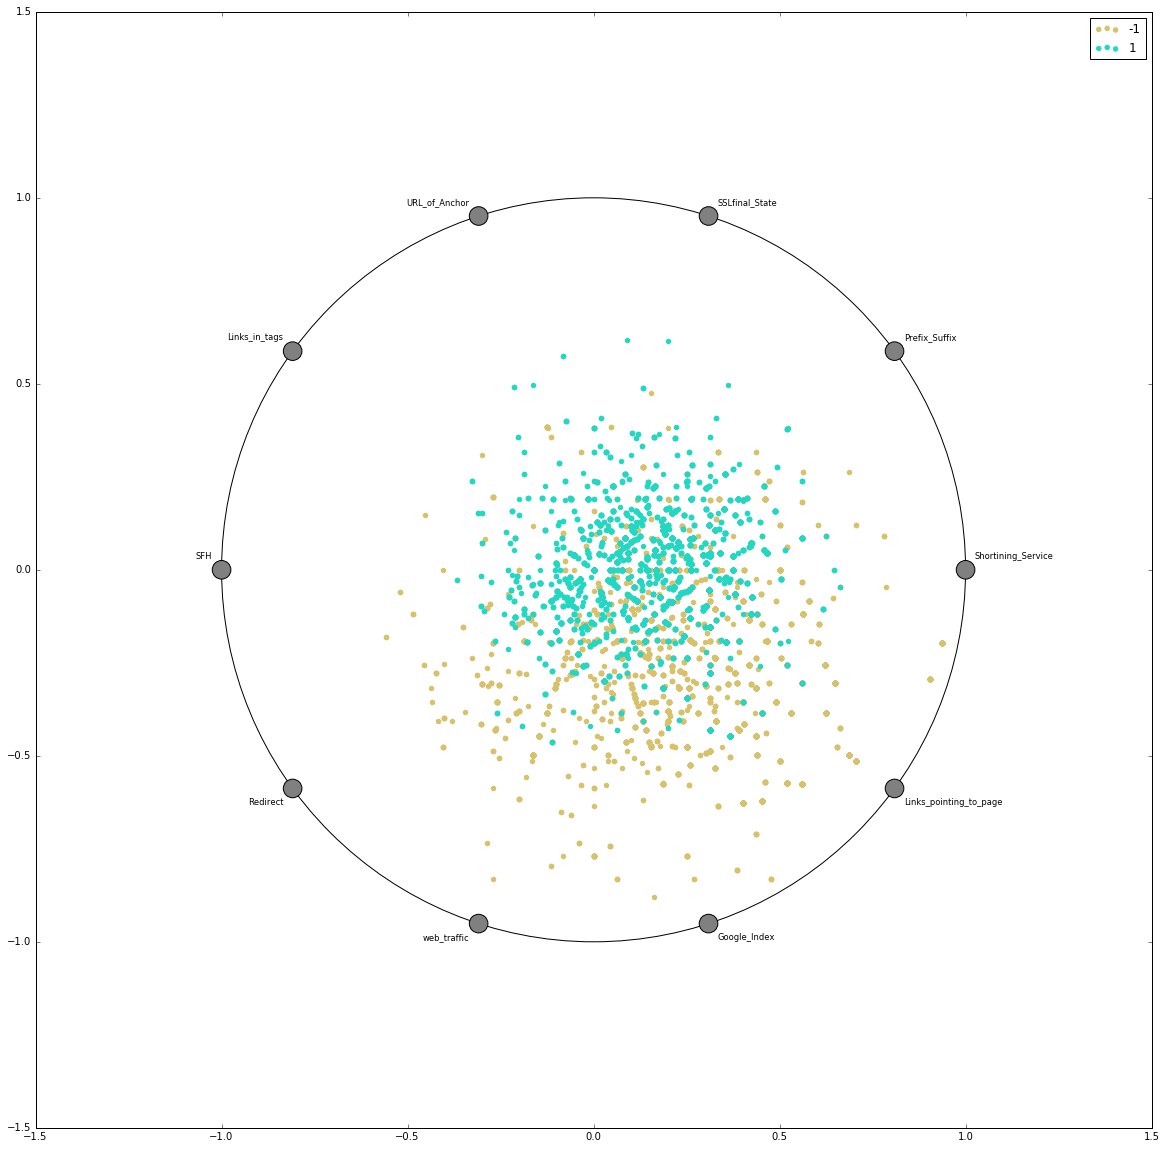

In [149]:
mod_features = df[['Shortining_Service', 'Prefix_Suffix', 'SSLfinal_State', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Redirect', 'web_traffic', 'Google_Index', 'Links_pointing_to_page', 'Result']]
plt.figure(figsize=(20,20))
radviz(mod_features, 'Result')
plt.show()

### Dimensionality reduction


Principal component analysis (PCA) (UNCLEAR WHAT THIS DOES)

In [72]:
#pca = PCA(n_components=2)
#new_features = pca.fit(features).transform(features)
#print(new_features)

Linear discriminant analysis (LDA) (UNCLEAR WHAT THIS DOES)


In [73]:
#lda = LDA(n_components=2)
#new_features = lda.fit(features, labels).transform(features)
#print(new_features)

# Data Loading and Management

Next I organized the data to be received by SciKit-Learn as a Bunch object.

In [32]:
import json 

meta = {
    'target_names': list(df2.Result.unique()),
    'feature_names': list(df2.columns),
    'categorical_features': {
        column: list(df2[column].unique())
        for column in df2.columns
        if df2[column].dtype == 'object'
    },
}

with open('meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

PICK BACK UP HERE

In [84]:
def load_data(root=DATA_DIR):
    # Construct the `Bunch` for the wheat dataset
    filenames     = {
        'meta': os.path.join(root, 'meta.json'),
        'rdme': os.path.join(root, 'README.md'),
        'data': os.path.join(root, 'Training_Dataset2.txt'),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = np.genfromtxt(filenames['data'], delimiter=',')[:,:-1]
    #np.loadtxt(filenames['data'],delimiter=',')
    
    # Extract the target from the data
    data   = dataset[:, 0:-1]
    target = dataset[:, -1]

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
DATA_DIR = os.getcwd()
dataset = load_data()

print (dataset.data.shape)
print (dataset.target.shape)

(11056, 30)
(11056,)


# Fitting and Evaluating Estimators (NOT DONE)

This is a function for fitting and evaluationg models. 

In [82]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    for train, test in KFold(dataset.data.shape[0], n_folds=12, shuffle=True):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print ("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print ("Validation scores are as follows:\n")
    print (pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'w') as f:
        pickle.dump(estimator, f)

    print ("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#splits     = cv.train_test_split(digits.data, digits.target, test_size=0.2)
#X_train, X_test, y_train, y_test = splits

#model      = RandomForestClassifier()
#model.fit(X_train, y_train)

#expected   = y_test
#predicted  = model.predict(X_test)

#print classification_report(expected, predicted)

Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

#splits     = cv.train_test_split(iris.data, iris.target, test_size=0.2)
#X_train, X_test, y_train, y_test = splits

#model      = GaussianNB()
#model.fit(X_train, y_train)

#expected   = y_test
#predicted  = model.predict(X_test)

#print classification_report(expected, predicted)

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

#splits     = cv.train_test_split(iris.data, iris.target, test_size=0.2)
#X_train, X_test, y_train, y_test = splits

#model      = LogisticRegression()
#model.fit(X_train, y_train)

#expected   = y_test
#predicted  = model.predict(X_test)

#print classification_report(expected, predicted)

In [ ]:
Use the best estimator to make predictions.